# Julia for the working scientist & engineer
## Part II: constrained optimization with JuMP
-----------


Mathieu Besançon  
POEMA network

<img src="https://julialang.org/assets/infra/logo.svg" alt="logo" width="200"/>

Run the notebooks (local or online): https://github.com/matbesancon/Julia_JuMP_workshop

# Outline

- Algebraic Modelling Languages & libraries for optimization
- Advanced Julia: broadcast and macros
- What is JuMP?
- Core concepts
- Getting started with examples

# Modelling optimization problems

Ideally:

$$\begin{align}
\min_{x}\,\, & f(x)\\
\text{s.t.} &  \\
& A x \leq b   \\
& x \in \mathcal{X}
\end{align}$$

## Using an Algebraic Modelling Language

A form of optimization-focused Domain-Specific Language (DSL).  
Close enough to the original syntax:
```
set rows;
set cols;

param A{rows, cols};
param b{rows};

var x {ncols} in Xset;

minimize f(x)

subject to:
    forall {i in rows}
        sum {j in cols} A{i,j} * x{j} <= b{i}

```

## From static model to algorithm design

- Column / row generation?
- Lazy constraints and cuts?
- Extending to custom sets?

Limits of AMLs $\Rightarrow$ programming interfaces

Example from CPLEX tutorials:

```
# instantiating
IloModel model(env);
IloNumVarArray vars(env);
vars.add(IloNumVar(env, 0.0, 40.0));
vars.add(IloNumVar(env));
vars.add(IloNumVar(env));
model.add(IloMaximize(env, vars[0] + 2 * vars[1] + 3 * vars[2]));
model.add( - vars[0] +     vars[1] + vars[2] <= 20);
model.add(   vars[0] - 3 * vars[1] + vars[2] <= 30);

# solving
IloCplex cplex(model);
if ( !cplex.solve() ) {
 env.error() << "Failed to optimize LP." << endl;
 throw(-1);
}

# fetching results
IloNumArray vals(env);
env.out() << "Solution status = " << cplex.getStatus() << endl;
env.out() << "Solution value = " << cplex.getObjValue() << endl;
cplex.getValues(vals, vars);
env.out() << "Values = " << vals << endl;
```

## Modelling with Programming Interfaces

- arbitrary algorithms (as long as exposed by solvers)
- directly dependent on solver  
    $\rightarrow$ "did you try with another solver?"   ¯\_(ツ)_/¯
- distance between model (paper) and implementation  
    $\rightarrow$ more chances for errors  
    $\rightarrow$ more software skills required

## Embedded Algebraic Modelling Languages (E-AML)

**Embed** a modelling language within another programming language.  

- Familiar syntax from your favourite programming language;
- Optimization-specififc syntax;
- Used as a library for algorithm design;
- Best of both world?

# JuMP, an E-AML in Julia

<img src="https://jump.dev/assets/jump-logo-with-text.svg" alt="logo" width="100"/>

- Almost as old as Julia itself (appendix of J. Bezanson's thesis)
- An organization supported by NumFocus (pandas, scipy, jupyter, stan, Julia itself)

Aim: unified modelling interface for **structured**, constrained optimization

# Two Julia notions on the side

## Macros

Macros are functions that take **source code** in input.
`f(x)` $\rightarrow$ function, `@f(x)` $\rightarrow$ macro.  

Normal code execution:  
`f(g(x))` evaluates `g(x)`, passed to `f`.

In a macro:
`@f(g(x))`: the `@f` macro takes the **code** `"g(x)"`, and can manipulate it.

In [1]:
@show(1 + 3 + rand());

1 + 3 + rand() = 4.247647748607024


## Broadcasting

Notion of "element-wise" operation.

In [2]:
A = [
    0 1
    1 0
]
@show A^2;  # A * A
@show A.^2; # A_ij^2 ∀ ij

A ^ 2 = [1 0; 0 1]
A .^ 2 = [0 1; 1 0]


In [3]:
using JuMP
import Clp
import Cbc

In [4]:
m = Model()

# scalars
@variable(m, x)
@variable(m, 1 <= y <= π)

@variable(m, z[i=1:5,j=1:10], Bin)

@variable(m, 2.5 <= Δ[i=1:5,j=i:2i, k=2:5] <= 3.5 + i)

# fancier indexing
product_type = ["flour", "eggs", "milk"]
@variable(m, grocery_list[p = product_type] >= 0, Int);

In [5]:
@variable(m, number_pancakes >= 0, Int)

@constraint(m, x <= 3 * y)

@constraint(m, recipe_constraint_egg,
    number_pancakes <= 3 * grocery_list["eggs"]
)

@constraint(m, recipe_constraint_flour,
    number_pancakes <= 0.5 * grocery_list["flour"]
)
@constraint(m, recipe_constraint_milk,
    number_pancakes <= 0.2 * grocery_list["milk"]
);

In [6]:
println(m)

Feasibility
Subject to
 x - 3 y ≤ 0.0
 recipe_constraint_egg : number_pancakes - 3 grocery_list[eggs] ≤ 0.0
 recipe_constraint_flour : number_pancakes - 0.5 grocery_list[flour] ≤ 0.0
 recipe_constraint_milk : number_pancakes - 0.2 grocery_list[milk] ≤ 0.0
 y ≥ 1.0
 Δ[1,1,2] ≥ 2.5
 Δ[1,1,3] ≥ 2.5
 Δ[1,1,4] ≥ 2.5
 Δ[1,1,5] ≥ 2.5
 Δ[1,2,2] ≥ 2.5
 Δ[1,2,3] ≥ 2.5
 Δ[1,2,4] ≥ 2.5
 Δ[1,2,5] ≥ 2.5
 Δ[2,2,2] ≥ 2.5
 Δ[2,2,3] ≥ 2.5
 Δ[2,2,4] ≥ 2.5
 Δ[2,2,5] ≥ 2.5
 Δ[2,3,2] ≥ 2.5
 Δ[2,3,3] ≥ 2.5
 Δ[2,3,4] ≥ 2.5
 Δ[2,3,5] ≥ 2.5
 Δ[2,4,2] ≥ 2.5
 Δ[2,4,3] ≥ 2.5
 Δ[2,4,4] ≥ 2.5
 Δ[2,4,5] ≥ 2.5
 Δ[3,3,2] ≥ 2.5
 Δ[3,3,3] ≥ 2.5
 Δ[3,3,4] ≥ 2.5
 Δ[3,3,5] ≥ 2.5
 Δ[3,4,2] ≥ 2.5
 Δ[3,4,3] ≥ 2.5
 Δ[3,4,4] ≥ 2.5
 Δ[3,4,5] ≥ 2.5
 Δ[3,5,2] ≥ 2.5
 Δ[3,5,3] ≥ 2.5
 Δ[3,5,4] ≥ 2.5
 Δ[3,5,5] ≥ 2.5
 Δ[3,6,2] ≥ 2.5
 Δ[3,6,3] ≥ 2.5
 Δ[3,6,4] ≥ 2.5
 Δ[3,6,5] ≥ 2.5
 Δ[4,4,2] ≥ 2.5
 Δ[4,4,3] ≥ 2.5
 Δ[4,4,4] ≥ 2.5
 Δ[4,4,5] ≥ 2.5
 Δ[4,5,2] ≥ 2.5
 Δ[4,5,3] ≥ 2.5
 Δ[4,5,4] ≥ 2.5
 Δ[4,5,5] ≥ 2.5
 Δ[4,6,2] ≥ 2.5
 Δ[4,6,3] ≥ 2.5

In [7]:
# alternative syntax
product_quantities = Dict(
    "flour" => 0.5, "eggs" => 3, "milk" => 0.2,
)

for (product, quantity) in product_quantities
    @constraint(m, number_pancakes <= quantity * grocery_list[product])
end

In [8]:
product_prices = Dict(
    "flour" => 0.3, "eggs" => 1, "milk" => 2,
)

@objective(m, Min,
    sum(price * grocery_list[product] for (product, price) in product_prices)
)

0.3 grocery_list[flour] + grocery_list[eggs] + 2 grocery_list[milk]

## Setting an optimizer and solving

In [9]:
optimize!(m)

NoOptimizer: NoOptimizer()

In [10]:
set_optimizer(m, Clp.Optimizer)
optimize!(m)

MathOptInterface.UnsupportedConstraint{MathOptInterface.SingleVariable,MathOptInterface.ZeroOne}: MathOptInterface.UnsupportedConstraint{MathOptInterface.SingleVariable,MathOptInterface.ZeroOne}: `MathOptInterface.SingleVariable`-in-`MathOptInterface.ZeroOne` constraint is not supported by the model.

In [11]:
# 3rd attempt, appropriate solver
set_optimizer(m, Cbc.Optimizer)
optimize!(m)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 0 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Knapsack was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Clique was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
MixedIntegerRounding2 was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
FlowCover was tried 0 times and created 

In [12]:
# reduce verbosity
MOI.set(m, MOI.Silent(), true)
optimize!(m)

## Getting results

In [13]:
# did we solve it optimally
@show termination_status(m)
@show primal_status(m)
@show dual_status(m);

termination_status(m) = MathOptInterface.OPTIMAL
primal_status(m) = MathOptInterface.FEASIBLE_POINT
dual_status(m) = MathOptInterface.NO_SOLUTION


In [14]:
# single value
JuMP.value(x)

0.0

In [15]:
# objective value
JuMP.objective_value(m)

0.0

In [16]:
# . before () for element-wise call
JuMP.value.(z)

5×10 Array{Float64,2}:
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0

## Value of arbitrary expression

In [17]:
x - sum(z)

x - z[1,1] - z[2,1] - z[3,1] - z[4,1] - z[5,1] - z[1,2] - z[2,2] - z[3,2] - z[4,2] - z[5,2] - z[1,3] - z[2,3] - z[3,3] - z[4,3] - z[5,3] - z[1,4] - z[2,4] - z[3,4] - z[4,4] - z[5,4] - z[1,5] - z[2,5] - z[3,5] - z[4,5] - z[5,5] - z[1,6] - z[2,6] - z[3,6] - z[4,6] - z[5,6] - z[1,7] - z[2,7] - z[3,7] - z[4,7] - z[5,7] - z[1,8] - z[2,8] - z[3,8] - z[4,8] - z[5,8] - z[1,9] - z[2,9] - z[3,9] - z[4,9] - z[5,9] - z[1,10] - z[2,10] - z[3,10] - z[4,10] - z[5,10]

In [18]:
JuMP.value(x - sum(z))

0.0

In [19]:
JuMP.has_duals(m)

false

# Advanced examples

## Regularized linear regression

$a x_i + b = y_i + \varepsilon_i$

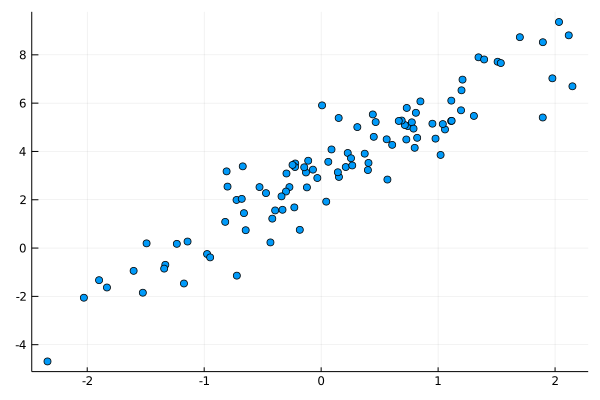

In [20]:
using Plots

x = randn(100)
y = randn(100) .+ 2.5 * x .+ 3;

scatter(x, y, legend = nothing)

In [21]:
import Ipopt # quadratic terms

a_values = Float64[]
b_values = Float64[]
penalty_values = [0.5, 10.0, 100.0]

for λ in penalty_values
    regression = Model(Ipopt.Optimizer)
    @variable(regression, a)
    @variable(regression, b)
    @expression(regression,
        quad_error[i=1:100],
        (a * x[i] + b - y[i])^2
    )
    @objective(regression, Min, sum(quad_error) + λ * (a^2 + b^2))
    MOI.set(regression, MOI.Silent(), true)
    optimize!(regression)
    
    push!(a_values, JuMP.value(a))
    push!(b_values, JuMP.value(b))
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

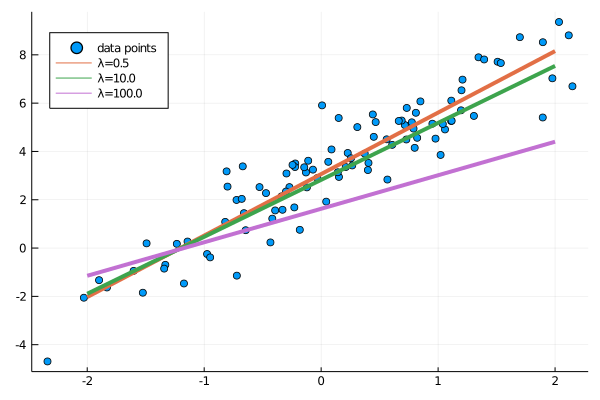

In [22]:
p = scatter(x, y, label="data points", legend=:topleft)
for j in eachindex(penalty_values)
    λ = penalty_values[j]
    plot!(p, [-2, 2], [-2 * a_values[j] + b_values[j], 2 * a_values[j] + b_values[j]], label = "λ=$λ", width=4)
end
p

In [23]:
a_values = Float64[]
b_values = Float64[]
penalty_values = [0.01, 0.5, 10.0, 100.0]
regression = Model(Ipopt.Optimizer)
@variable(regression, a)
@variable(regression, b)
@expression(regression,
    quad_error[i=1:100],
    (a * x[i] + b - y[i])^2
)
MOI.set(regression, MOI.Silent(), true)

for λ in penalty_values
    @objective(regression, Min, sum(quad_error) + λ * (a^2 + b^2))
    optimize!(regression)    
    push!(a_values, JuMP.value(a))
    push!(b_values, JuMP.value(b))
end

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

## Conic optimization & sparse correlation matrix

Estimating a correlation matrix from data.  

A vintage paper with familiar names:  
http://www.optimization-online.org/DB_FILE/2003/09/729.pdf  
A Semidefinite Programming Approach, for the Nearest Correlation Matrix Problem  
M. F. Anjos, N. J. Higham, P.L. Takouda, H. Wolkowicz, 2003

Let's add sparsity:

$$\begin{align}
\min_C & \|C - cor(X)\|_F^2 \\
\text{s.t.} &\\
& C_{ii} = 1 \,\,\,\,\forall i \\
& C \succeq 0 \\
& C_{ij} = 0 \,\,\,\,\forall (i,j)\in \mathcal{S}
\end{align}$$

### Generating data

$X_{1,2,3}$ correlated with $X_{4, 5, 6}$

In [24]:
using Statistics

n = 6
X1 = randn(1000, 3)
X2 = randn(1000, 3) .+ 1.1 .* X1
X = [X1 X2]
cor(X)

6×6 Array{Float64,2}:
  1.0         -0.00327027  0.0570165    0.752861    -0.030622    0.0337707
 -0.00327027   1.0         0.0301278    0.0226206    0.747055    0.0469962
  0.0570165    0.0301278   1.0          0.00476154   0.0634156   0.748426
  0.752861     0.0226206   0.00476154   1.0         -0.0196301  -0.0291189
 -0.030622     0.747055    0.0634156   -0.0196301    1.0         0.0673077
  0.0337707    0.0469962   0.748426    -0.0291189    0.0673077   1.0

In [25]:
import SCS # conic solver
using LinearAlgebra

In [26]:
sparse_corr = Model(SCS.Optimizer)
MOI.set(sparse_corr, MOI.Silent(), true)
@variable(sparse_corr, C[1:n, 1:n] in PSDCone())
@constraint(sparse_corr, unit_diagonal[i=1:6], diag(C)[i] == 1);

In [27]:
# add sparsity pattern
for (i, j) in [(1, 2), (1, 3), (5, 6)]
    con = @constraint(sparse_corr, C[i,j] == 0)
    JuMP.set_name(con, "sparse_$(i)_$(j)")
end
@objective(sparse_corr, Min,
    sum((C - cor(X)).^2)
);

In [28]:
optimize!(sparse_corr)

In [29]:
JuMP.value.(C)

6×6 Array{Float64,2}:
  1.0         6.70515e-7  4.56314e-8   0.752859    -0.0306217    0.0337707
  6.70515e-7  1.0         0.0301277    0.0226207    0.747054     0.0469958
  4.56314e-8  0.0301277   0.999999     0.00476165   0.0634151    0.748425
  0.752859    0.0226207   0.00476165   1.0         -0.0196301   -0.0291187
 -0.0306217   0.747054    0.0634151   -0.0196301    1.0         -3.12266e-7
  0.0337707   0.0469958   0.748425    -0.0291187   -3.12266e-7   0.999999

# Model transformations

[Dualization.jl](https://github.com/JuliaOpt/Dualization.jl) for automatic computation of dual models.

$$
\begin{align}
& \text{Variable-in-cone model:}\\
\min_x\,\,\, & c \cdot x\\
& A x = b\\
& x \in \mathcal{K}\\
&\\
& \text{Affine-map-in-cone model:}\\
&\\
\min_x\,\,\, & c \cdot x\\
& A x - b \in \mathcal{K}
\end{align}$$


In [30]:
using Dualization

In [31]:
sparse_corr

A JuMP Model
Minimization problem with:
Variables: 21
Objective function type: GenericQuadExpr{Float64,VariableRef}
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 9 constraints
`Array{VariableRef,1}`-in-`MathOptInterface.PositiveSemidefiniteConeTriangle`: 1 constraint
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: SCS
Names registered in the model: C, unit_diagonal

In [32]:
dual_sparse_corr = Dualization.dualize(sparse_corr, SCS.Optimizer, dual_names = DualNames("", ""))
print(dual_sparse_corr)

Max -quadslack_C[1,1]² - 2 quadslack_C[1,2]² - quadslack_C[2,2]² - 2 quadslack_C[1,3]² - 2 quadslack_C[2,3]² - quadslack_C[3,3]² - 2 quadslack_C[1,4]² - 2 quadslack_C[2,4]² - 2 quadslack_C[3,4]² - quadslack_C[4,4]² - 2 quadslack_C[1,5]² - 2 quadslack_C[2,5]² - 2 quadslack_C[3,5]² - 2 quadslack_C[4,5]² - quadslack_C[5,5]² - 2 quadslack_C[1,6]² - 2 quadslack_C[2,6]² - 2 quadslack_C[3,6]² - 2 quadslack_C[4,6]² - 2 quadslack_C[5,6]² - quadslack_C[6,6]² + unit_diagonal[4]_1 + unit_diagonal[2]_1 + unit_diagonal[3]_1 + unit_diagonal[5]_1 + unit_diagonal[6]_1 + unit_diagonal[1]_1 + 9.407615018214509
Subject to
 C[1,1] : unit_diagonal[1]_1 + _1 - 2 quadslack_C[1,1] = -2.0
 C[1,2] : sparse_1_2_1 + 2 _2 - 4 quadslack_C[1,2] = 0.013081094025689716
 C[2,2] : unit_diagonal[2]_1 + _3 - 2 quadslack_C[2,2] = -2.0
 C[1,3] : sparse_1_3_1 + 2 _4 - 4 quadslack_C[1,3] = -0.22806609540203193
 C[2,3] : 2 _5 - 4 quadslack_C[2,3] = -0.12051130305305092
 C[3,3] : unit_diagonal[3]_1 + _6 - 2 quadslack_C[3,3] = -2

In [33]:
MOI.set(dual_sparse_corr, MOI.Silent(), true)
optimize!(dual_sparse_corr)

In [34]:
@show (objective_value(dual_sparse_corr)-objective_value(sparse_corr));

objective_value(dual_sparse_corr) - objective_value(sparse_corr) = -2.591275373831081e-6


## Model transformation

What are the extreme vertices of my feasible set? JuliaPolyhedra & computational geometry

In [35]:
using Polyhedra

m = Model()
@variable(m, 0 ≤ x[1:3] ≤ 1)
@constraint(m, sum(x) ≤ 1)

poly = polyhedron(m)
vrep(poly)

V-representation Polyhedra.Hull{Float64,Array{Float64,1},Int64}:
4-element iterator of Array{Float64,1}:
 [0.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]
 [0.0, 1.0, 0.0]
 [0.0, 0.0, 1.0]

# What is JuMP **not good** for?

- Non-linear optimization is still work in progress
- More suited tools:
    - [BlackBoxOptim.jl](https://github.com/robertfeldt/BlackBoxOptim.jl)
    - [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl) and [JuliaNLSolvers](https://github.com/JuliaNLSolvers/)
    - [JuliaSmoothOptimizers](https://juliasmoothoptimizers.github.io)
    - [JuliaManifolds/ManOpt.jl](https://github.com/JuliaManifolds/Manopt.jl) for optimization on manifolds
- Still dependent on Float64 (no optimization over complex, symbolic numbers, autodiff)

# Wrapping up

- JuMP, and E-AML are a great compromise between **model-friendly** and **algorithm-friendly**
- One of the rare tools bridging LP, conic, integer optimization
- Can be integrated in other packages and functions  
    $\rightarrow$ no workflow interruption

## Learning more

**https://jump.dev**

Advanced tutorials (conic, approximations, non-linear, graph-based problems) on https://jump.dev/JuMP.jl/stable/examples/basic/

- [DiffOpt.jl](https://github.com/jump-dev/DiffOpt.jl/): differentiation of convex problems
- [Coluna.jl](https://atoptima.github.io/Coluna.jl/stable/start/): row and column generation framework on top of JuMP
- [Tulip.jl](https://github.com/ds4dm/Tulip.jl): pure-Julia interior-point solver with abstract algebra
- [FrankWolfe.jl](https://github.com/ZIB-IOL/FrankWolfe.jl): large-scale first-order optimization using JuMP as underlying linear oracle